## Get Transcripts from YouTube Videos

In [67]:
from youtube_transcript_api import YouTubeTranscriptApi
import re

def get_youtube_transcripts(video_ids):
    """
    Fetches and concatenates transcripts from a list of YouTube video IDs.
    
    Args:
    video_ids (list): List of YouTube video IDs as strings.
    
    Returns:
    str: Concatenated transcript text.
    """
    transcript_text = ''
    for video_id in video_ids:
        try:
            # Fetch transcript
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            # Concatenate transcript texts
            transcript_text += ' '.join([transcript['text'] for transcript in transcript_list]) + ' '
            transcript_text = transcript_text.lower()
        except Exception as e:
            print(f"Error fetching transcript for video ID {video_id}: {e}")
    
    
    return transcript_text


#List your youtube video ids from its URL:
video_ids = ['UfbyzK488Hk', 'uB0n4IZmS34'] #Databricks 2024
transcripts = get_youtube_transcripts(video_ids)

#print(transcripts)

# Assuming `transcripts` is the variable containing your transcript text
# Split the text into words
words = transcripts.split()

# Get the number of words
num_words = len(words)

print("Number of words in the transcript:", num_words)

Number of words in the transcript: 53017


I'm late on my Databricks Data and AI Summit take. It's in-flight. However, this year's *felt* more... data focused..

So, I thought I'd put that hunch to a test. Logic:

1) Pull Day 1 & Day 2 keynote transcripts from YT for 2023 and 2024.
2) Fix words with some regex. BTW, YouTube thinks you're 'data braks' and SQL is 'sequel'.
3) Calc the # of times these 3 keywords were spoken | total words spoken. 
4) Graph. 

I was right, it was ~marginally more data focused. Loved the summit! So much to put hands on. More thoughts to come. 

In [14]:
len(transcripts)

283235

## Fix jargon and other things that get fouled up when youtube translates human speech

In [15]:
databricks_variations = [
    r'\bdata breaks\b', r'\bdata bricks\b', r'\bdata brick\b', r'\bdata breakes\b', r'\bdata bri\b', r'\bdata brak\b', r'\bdata braks\b',
    r'\bdatabrick\b', r'\bdatabriks\b', r'\bdata briks\b', r'\bdata breakers\b', r'\bdata brakes\b', r'\bdatab bricks\b',
    r'\bdata brake\b', r'\bdata break\b', r'\bdatab briak\b', r'\bdatab briaks\b', r'\bdatab brick\b', r'\bdatab bricks\b',
    r'\bdata brecks\b', r'\bdata briak\b', r'\bdata brook\b', r'\bdata bir\b', r"\bdata burk's\b", r'\bdata brs\b'
]
for variation in databricks_variations:
    transcripts = re.sub(variation, 'databricks', transcripts, flags=re.IGNORECASE)

# fix other speech foulups
transcripts = re.sub('sequel', 'sql', transcripts, flags=re.IGNORECASE)

## Remove Stopwords, WordCloud Keyword Frequency

[nltk_data] Downloading package stopwords to /Users/eric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


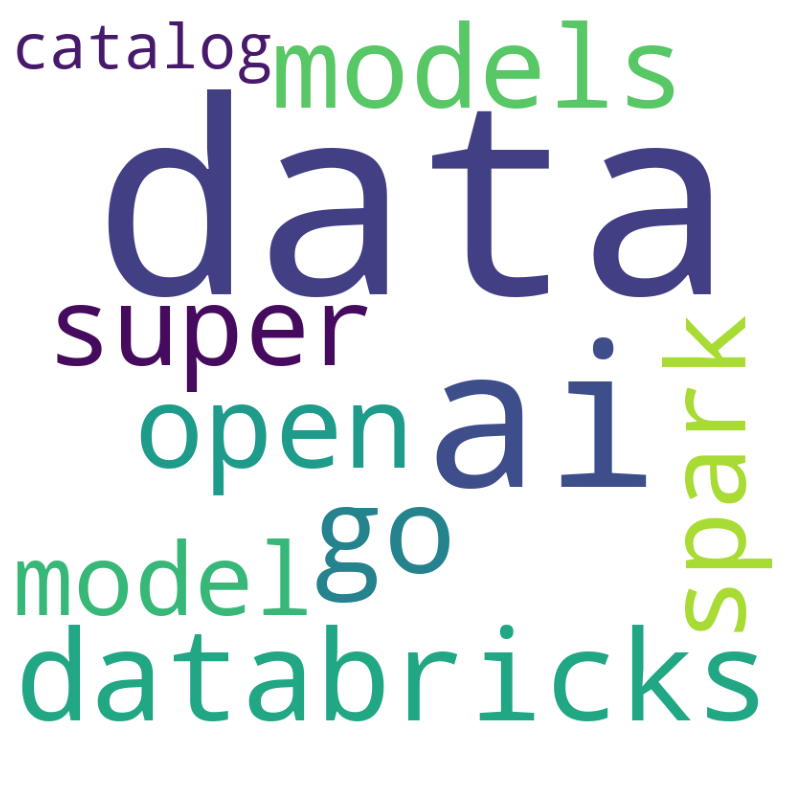

In [16]:
# Remove STOP WORDS like "at", "the" and "and" - then create a word cloud by frequency of key terms in the transcript
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Download dics of words
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize
words = word_tokenize(transcripts)

# Filter out stop words and junk words
stop_words = set(stopwords.words('english'))
more_stop_words = ['use', 'well', 'azure', 'new', 'one', 'know', 'see', 'lot', 'okay', 'got', 'make', 'actually', 'let', 'sort', 'yeah', 'able', 'need', 'going', 'show', 'take', \
                   'microsoft', 'thomas', 'aws', 'help', 'gon', 'na', 'back', 'us', 'um', 'uh', 'way', 'right', 'much', 'really', 'want', 'get', 'google', 'amazon', 'also', 'like' \
                   'thank', 'like', 'thank', 'great', 'including', 'using', 'applause', 'today', 'across', 'find']
all_stop_words = stop_words.union(more_stop_words)
keywords = [word.lower() for word in words if word.isalpha() and word.lower() not in all_stop_words]

# Calculate freq. dist. of the words remaining 'keywords'
freq_dist = nltk.FreqDist(keywords)

# Get the top N most common, after remove basic words, replace (N) w/ the TopN you want.
common_words = freq_dist.most_common(10)

# Create a string
word_freq = {word: freq for word, freq in common_words}

# WordCloud (WC)
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10)

# Generage the WC
wordcloud.generate_from_frequencies(word_freq)

# Plot and show the WC           
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)
plt.axis("off") 
plt.show()

In [20]:
freq_dist

FreqDist({'data': 625, 'ai': 293, 'databricks': 134, 'go': 124, 'open': 113, 'models': 112, 'super': 102, 'spark': 102, 'model': 102, 'catalog': 94, ...})

In [74]:
import plotly.graph_objects as go

# Define the word frequencies and total words for each year
word_frequencies_2024 = {'data': 625, 'ai': 293, 'databricks': 134, 'go': 124, 'open': 113, 'models': 112, 'super': 102, 'spark': 102, 'model': 102, 'catalog': 94}
word_frequencies_2023 = {'data': 556, 'ai': 347, 'model': 181, 'models': 180, 'think': 176, 'time': 130, 'databricks': 128, 'people': 126, 'lake': 122, 'things': 122}
total_words_2024 = 53017
total_words_2023 = 57079

# List of words to compare
words_to_compare = ['data', 'ai', 'model']

# Calculate the percentage of each word relative to the total words spoken each year
def calculate_percentage(frequencies, total_words):
    return {word: (frequencies.get(word, 0) / total_words) * 100 for word in words_to_compare}

percentages_2024 = calculate_percentage(word_frequencies_2024, total_words_2024)
percentages_2023 = calculate_percentage(word_frequencies_2023, total_words_2023)

# Prepare data for Plotly
years = ['2023', '2024']
data_percentages = [percentages_2023['data'], percentages_2024['data']]
ai_percentages = [percentages_2023['ai'], percentages_2024['ai']]
model_percentages = [percentages_2023['model'], percentages_2024['model']]

# Create traces
trace1 = go.Bar(x=years, y=data_percentages, name='Data', marker_color='#98102A')
trace2 = go.Bar(x=years, y=ai_percentages, name='AI', marker_color='#2272B4')
trace3 = go.Bar(x=years, y=model_percentages, name='Model', marker_color='#FFAB00')

# Create layout with right-justified title and add logo
layout = go.Layout(
    title={
        'text': ''' Summit Keyword Freq Comparison<br>(as Percentage of Total Words)''',
        'x': 1,  # Right justify the title
        'xanchor': 'right',
        'yanchor': 'top'
    },
    xaxis=dict(title='Summit Year'),
    yaxis=dict(title='Percentage of Total Words'),
    barmode='group',
    width=600,  # Set the width to make the plot more narrow
    images=[dict(
        source="https://upload.wikimedia.org/wikipedia/commons/6/63/Databricks_Logo.png",
        xref="paper", yref="paper",
        x=0, y=1.05,
        sizex=0.40, sizey=0.40,
        xanchor="left", yanchor="bottom"
    )]
)

# Create figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Show plot
fig.show()